In [4]:
%load_ext autoreload
%autoreload 2

import os
from utils.config import Config
from featureanalysis.featureanalysis import parse_caller_feature
from utils.config import Config
from utils.viz import *
from utils.table import *
from utils.metrics import *
from utils.calltable import *
from utils.calltableseries import *
from utils.groundtruth import *
from utils.metricsseries import *
from utils.venn import venn6, get_labels

import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate

import seaborn as sns 
import matplotlib.pyplot as plt

if not os.getcwd().endswith('cfdna_snv_benchmark'):
    os.chdir('../')
print('Current working directory: {}'.format(os.getcwd()))

config = Config("config/", "config_viz.yaml")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Current working directory: /Users/hanae/Repositories/cfdna_snv_benchmark


In [2]:
# Chomosome

mixtureids =  ['CRC-1014_180816-CW-T_CRC-1014_090516-CW-T', 'CRC-986_100215-CW-T_CRC-986_300316-CW-T', 'CRC-123_310715-CW-T_CRC-123_121115-CW-T']
mixtureid = 'CRC-986_100215-CW-T_CRC-986_300316-CW-T'
#mixtureid = 'CRC-1014_180816-CW-T_CRC-1014_090516-CW-T'
#mixtureid = 'CRC-123_310715-CW-T_CRC-123_121115-CW-T'
reload = False
save = False
fixedvars=['coverage', 'ctdna']
filterparam = 'all'

markers = ['o', '^', 'X']
linestyles = ['-', '-', '-']
color_dict = {config.methods[i]: config.colors[i] for i in range(len(config.methods))}

muttypes = ['snv', 'indel']
metrics = ['auprc', 'precision', 'recall']

chrom = 'all'

############# CRC-986_100215-CW-T_CRC-986_300316-CW-T ############
mixture ['data', 'mixtures']
['3', '4', '5', '6', '7', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19']
mixture ['data', 'mixtures']
['3', '4', '5', '6', '7', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19']
mixture ['data', 'mixtures']
['3', '4', '5', '6', '7', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19']
(806723, 405) (5627, 405) (52639, 405)
                                                          tf       cov
mixture_CRC-986_100215-CW-T_70x_CRC-986_300316-...  41.89990   69.9981
mixture_CRC-986_100215-CW-T_70x_CRC-986_300316-...  19.55335  149.7495
mixture_CRC-986_100215-CW-T_50x_CRC-986_300316-...  13.96675  150.0000
mixture_CRC-986_100215-CW-T_70x_CRC-986_300316-...  11.73160  248.9590
mixture_CRC-986_100215-CW-T_30x_CRC-986_300316-...   8.37985  150.0135
mixture_CRC-986_100215-CW-T_20x_CRC-986_300316-...   5.58630  150.0375
mixture_CRC-986_100215-CW-T_10x_CRC-9

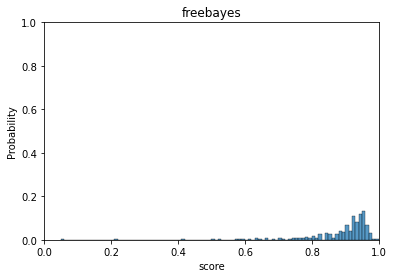

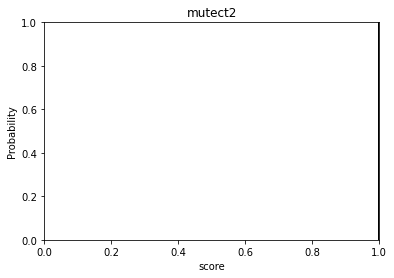

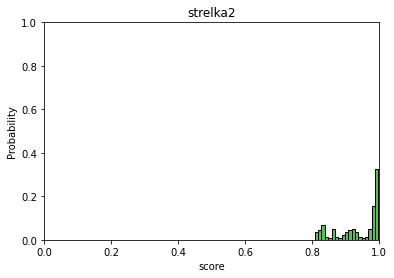

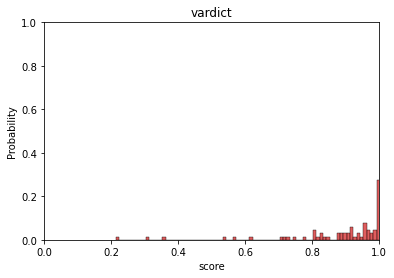

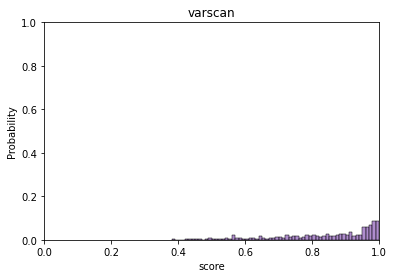

In [3]:
fixedvar = 'coverage'
if fixedvar == 'coverage':
    seriesorder = [(70, 0), (70, 80), (50, 100), (30, 120), (20, 130), (10, 140), (5, 145)]
    xaxis = 'tumor burden'
elif fixedvar == 'ctdna':
    seriesorder = [(70, 0), (70, 80), (70, 180)]
    xaxis = 'coverage'
print('############# {} ############'.format(mixtureid))
if mixtureid ==  'CRC-1014_180816-CW-T_CRC-1014_090516-CW-T':
    chroms = [str(c) for c in range(1,23) if c !=17 and c !=8 and c!=5 and c!=19 and c!=20 and c!=21 and c!=22]
elif mixtureid ==  'CRC-986_100215-CW-T_CRC-986_300316-CW-T':
    chroms = [str(c) for c in range(1,23) if c !=1 and c!= 2 and c !=8 and c!=20 and c!=21 and c!=22] 
else:
    chroms = [str(c) for c in range(1,23) if c !=1 and c!= 2 and c !=6 and c!=20 and c!=21] 
calltables = {'sampleid':[], 'tf':[], 'cov':[], 'snv':[], 'indel':[], 'snp':[]}
aux_all = []
calltable_snv, aux = get_calltableseries(config, mixtureid, chroms, muttype='snv', filterparam=filterparam, reload=reload, save=save)
calltable_indel, aux = get_calltableseries(config, mixtureid, chroms, muttype='indel', filterparam=filterparam, reload=reload, save=save)
calltable_snp, aux = get_calltableseries(config, mixtureid, chroms, muttype='snp', filterparam=filterparam, reload=reload, save=save)
print(calltable_snv.shape, calltable_indel.shape, calltable_snp.shape)
print(aux)
plasmasample = '_'.join(mixtureid.split('_')[:2])
print(plasmasample)
healthysample = '_'.join(mixtureid.split('_')[2:])
print(healthysample)
calltables['snv'].append(calltable_snv)
calltables['indel'].append(calltable_indel)
calltables['snp'].append(calltable_snp)
calltables['sampleid'] = mixtureid 
calltables['tf'] = np.unique([cn.split('_')[0] for cn in list(calltable_snv.columns)])[:-5].astype(float)
calltables['snv'] = pd.concat(calltables['snv'])
calltables['indel'] = pd.concat(calltables['indel'])
calltables['snp'] = pd.concat(calltables['snp'])
dilutionseries = aux.T[['mixture_' + '_'.join(mixtureid.split('_')[:2]) + '_' + str(s[0]) + 'x_' + '_'.join(mixtureid.split('_')[2:4]) + '_' + str(s[1]) + 'x' for s in seriesorder]].T
#for muttype in muttypes:
muttype = 'snv'
refsample = 'undiluted'
if muttype == 'snv':
    gtm = 4
else:  # elif muttype == 'indel':
    gtm = 2
print(max(aux['tf']))
if mixtureid ==  'CRC-986_100215-CW-T_CRC-986_300316-CW-T':
    gtm = 3
    refsample = 'tissue'
    calltablesseries  = generate_groundtruth(config, calltables[muttype], aux['tf'], ground_truth_method='tissue', muttype=muttype,
                                        matchedtissuepath=os.path.join('data', 'matchedtissue', 'NCC_CRC-986_100215-T1W', 'calls', 'NCC_CRC-986_100215-T1W_snv_calls_PASS_exome.csv'))
else:
    calltablesseries = generate_groundtruth(config, calltables[muttype], aux['tf'], ground_truth_method=gtm, muttype=muttype)

In [ ]:
for method in config.methods_tissue:
    
    callmethod_snv_list = []
    for serie in [(70, 0), (70, 80), (50, 100), (30, 120), (20, 130), (10, 140), (5, 145)]:
        st, sn = serie
        print(serie)
        for chrom in chroms:
            print(chrom)
            callmethod_snv, _, _ = parse_caller_feature(
                'data/mixtures/mixtures_chr'+chrom+'/mixtures_chr'+chrom+'_CRC-986_100215-CW-T_CRC-986_300316-CW-T/mixture_chr'+chrom+'_CRC-986_100215-CW-T_'+str(st)+'x_CRC-986_300316-CW-T_'+str(sn)+'x',
                method, save=False)
            callmethod_snv.drop(['ANN'], axis=1, inplace=True)
            #print(callmethod_snv.shape)
            #print(list(callmethod_snv.columns))
            #print(callmethod_snv.head())
            callmethod_snv_list.append(callmethod_snv)
    callmethod_snv_allchrom = pd.concat(callmethod_snv_list)

    # callmethod_snv_allchrom = pd.concat([callmethod_snv_allchrom, calltablesseries['truth']], axis=1)
    callmethod_snv_allchrom = callmethod_snv_allchrom.join(calltablesseries[['truth']], how='outer')
    callmethod_snv_allchrom['truth'].fillna(False, inplace=True)
    callmethod_snv_allchrom['truth'].value_counts()
    #callmethod_snv_allchrom.head()
    
    features = list(callmethod_snv_allchrom.columns)
    for x in [method, method+'_score',  method+'_vaf', 'type', 'alt', 'chrom', 'pos', 'ref', method+'_totcov', method+'_altcov']:
        print(x)
        features.remove(x)
    print(features)
    
    #callmethod_snv_allchrom = pd.concat([callmethod_snv_allchrom, calltablesseries['truth']], axis=1)
    callmethod_snv_allchrom['truth'].fillna(False, inplace=True)
    callmethod_snv_allchrom['truth'].value_counts()
    
    callmethod_snv_allchrom[method].value_counts()
    callmethod_snv_allchrom[method][callmethod_snv_allchrom[method] == 'PASS'] = 1
    callmethod_snv_allchrom[method][callmethod_snv_allchrom[method] != 1] = 0
    
    forbiden_features = ['AF', 'OLD_VARIANT', 'TYPE', "cosmid_id", 'AN', "NS", 'CIGAR']
    score_features = ['ODDS', 'TLOD', 'SomaticEVS', 'SSF', 'SPV']
    print(features)
    
    plt.figure()
    ax = plt.subplots(figsize=(10,10))
    plt.rc('font', size=20) 
    for feature in features:
        print(feature)
        test = 0
        try:
            pred = callmethod_snv_allchrom[feature].fillna(0).astype(float)
            test = 1
        except:
            try: 
                pred = callmethod_snv_allchrom[feature].str.split(',').str[0].fillna(0).astype(float)
                test = 1
            except:    
                test = 0
        if test == 1 and feature != 'truth' and feature not in forbiden_features:
            print('hello')
            #pred = callmethod_snv_allchrom[feature].fillna(0).astype(float)
            fpr, tpr, _ = roc_curve(callmethod_snv_allchrom['truth'].fillna(0), pred)
            if auc(fpr, tpr) < 0.5:
                print('invert')
                pred = -pred
            fpr, tpr, _ = roc_curve(callmethod_snv_allchrom['truth'].fillna(0), pred)
            print(auc(fpr, tpr))
            if auc(fpr, tpr) >= 0.9 and feature not in score_features:
                plot_roc_curve(fpr, tpr, estimator_name=feature, auc_score=auc(fpr, tpr), figax=ax, kwargs={'color':'r', 'lw': 3})
            if feature in score_features:
                plot_roc_curve(fpr, tpr, estimator_name=feature, auc_score=auc(fpr, tpr), figax=ax, kwargs={'color':'b', 'lw': 3})
            else:
                plot_roc_curve(fpr, tpr, estimator_name=None, auc_score=None, figax=ax, kwargs={'color':'grey', 'alpha': 0.5})
    plt.legend(bbox_to_anchor=(1,1), loc="upper left")
    plt.title('ROC curve of each feature of caller {}'.format(method))
    plt.show()
    #plt.grid()

In [ ]:
#for method in config.methods_tissue:
method = 'vardict'
callmethod_snv_list = []
for serie in [(70, 0), (70, 80), (50, 100), (30, 120), (20, 130), (10, 140), (5, 145)]:
    st, sn = serie
    print(serie)
    for chrom in chroms:
        print(chrom)
        callmethod_snv, _, _ = parse_caller_feature(
            'data/mixtures/mixtures_chr'+chrom+'/mixtures_chr'+chrom+'_CRC-986_100215-CW-T_CRC-986_300316-CW-T/mixture_chr'+chrom+'_CRC-986_100215-CW-T_'+str(st)+'x_CRC-986_300316-CW-T_'+str(sn)+'x',
            method, save=False)
        callmethod_snv.drop(['ANN'], axis=1, inplace=True)
        #print(callmethod_snv.shape)
        #print(list(callmethod_snv.columns))
        #print(callmethod_snv.head())
        callmethod_snv_list.append(callmethod_snv)
callmethod_snv_allchrom = pd.concat(callmethod_snv_list)

# callmethod_snv_allchrom = pd.concat([callmethod_snv_allchrom, calltablesseries['truth']], axis=1)
callmethod_snv_allchrom = callmethod_snv_allchrom.join(calltablesseries[['truth']], how='outer')
callmethod_snv_allchrom['truth'].fillna(False, inplace=True)
callmethod_snv_allchrom['truth'].value_counts()
#callmethod_snv_allchrom.head()

features = list(callmethod_snv_allchrom.columns)
for x in [method, method+'_score',  method+'_vaf', 'type', 'alt', 'chrom', 'pos', 'ref', method+'_totcov', method+'_altcov']:
    print(x)
    features.remove(x)
print(features)

#callmethod_snv_allchrom = pd.concat([callmethod_snv_allchrom, calltablesseries['truth']], axis=1)
callmethod_snv_allchrom['truth'].fillna(False, inplace=True)
callmethod_snv_allchrom['truth'].value_counts()

callmethod_snv_allchrom[method].value_counts()
callmethod_snv_allchrom[method][callmethod_snv_allchrom[method] == 'PASS'] = 1
callmethod_snv_allchrom[method][callmethod_snv_allchrom[method] != 1] = 0

forbiden_features = ['AF', 'OLD_VARIANT', 'TYPE', "cosmid_id", 'AN', "NS", 'CIGAR']
score_features = ['ODDS', 'TLOD', 'SomaticEVS', 'SSF', 'SPV']
print(features)

Xlist = []
for feature in features:
    print(feature)
    test = 0
    try:
        aux = callmethod_snv_allchrom[feature].fillna(0).astype(float)
        test = 1
    except:
        try: 
            aux = callmethod_snv_allchrom[feature].str.split(',').str[0].fillna(0).astype(float)
            test = 1
        except:    
            test = 0
    if test == 1 and feature != 'truth' and feature not in forbiden_features:
        Xlist.append(aux)
X = pd.concat(Xlist, axis=1)
y = callmethod_snv_allchrom['truth'].fillna(0)
print(X.shape, y.shape)

feature_name_dict = {}
for i, x in enumerate(list(X.columns)):
    feature_name_dict[i] = x
feature_name_dict

model = RandomForestClassifier()
grid = {
        'bootstrap': [True, False],
        'max_depth':  [10, 25, 50, 75, 100, None], #[10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
        'max_features': ['auto', 'sqrt'],
        'min_samples_leaf': [1, 2, 4],
        'min_samples_split': [2, 5, 10],
        'n_estimators': [200, 400, 600, 800, 1000] #, 1200, 1400, 1600, 1800, 2000]
   }
#gridsearch = RandomizedSearchCV(estimator=model, param_distributions=grid, n_jobs=1, scoring="roc_auc", n_iter=2, cv=5, verbose=6, random_state=0)
#gridsearch.fit(X, y)
#print(gridsearch.best_params_)
#model = model.set_params(**gridsearch.best_params_) # retrive best hyper params
model = model.set_params(**{'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 10, 'bootstrap': False})
cv = StratifiedKFold(n_splits=10, shuffle = True) # prepare 10-fold CV
cv_results = cross_validate(model, X, y, cv=cv, scoring=['roc_auc', 'average_precision'], return_estimator=True, verbose=6)


plt.rc('font', size=20) 
fi_pd_list = []
for idx, estimator in enumerate(cv_results['estimator']):
    fi_pd = pd.DataFrame(estimator.feature_importances_,
                         columns=['importance']).sort_values('importance', ascending=False)
    fi_pd_list.append(fi_pd)
feature_importances = pd.concat(fi_pd_list, axis=1)
feature_importances.columns = ['estimator_'+str(i) for i in range(10)]
feature_importances.index = feature_name_dict.values()
feature_importances.sort_values(by='estimator_0', ascending=False, inplace=True)
feature_importances = feature_importances[(feature_importances.T != 0).any()]
g = sns.catplot(data=feature_importances.T, kind="box",
                height=6, aspect=3.5);
g.map_dataframe(sns.stripplot,
                palette=["k"], dodge=True)
g.set_xticklabels(rotation=45)
plt.xlabel('Features')
plt.ylabel('Feature importance in Random Forest models in CV')
plt.title(method + ' feature importance analysis')
plt.show()

#for idx, estimator in enumerate(cv_results['estimator']):
#    print("Features sorted by their score for estimator {}:".format(idx))
#    feature_importances = pd.DataFrame(estimator.feature_importances_,
#                                       index = estimator.feature_names_in_,
#                                        columns=['importance']).sort_values('importance', ascending=False)
#    print(feature_importances)

(70, 0)
3
mixture_chr3_CRC-986_100215-CW-T_70x_CRC-986_300316-CW-T_0x
vardict
retrieving vardict 0 calls with f0.01;REJECT;REJECT tags out of 281
4
mixture_chr4_CRC-986_100215-CW-T_70x_CRC-986_300316-CW-T_0x
vardict
retrieving vardict 0 calls with f0.01;REJECT;REJECT tags out of 137
5
mixture_chr5_CRC-986_100215-CW-T_70x_CRC-986_300316-CW-T_0x
vardict
retrieving vardict 0 calls with f0.01;REJECT;REJECT tags out of 189
6
mixture_chr6_CRC-986_100215-CW-T_70x_CRC-986_300316-CW-T_0x
vardict
retrieving vardict 0 calls with f0.01;REJECT;REJECT tags out of 230
7
mixture_chr7_CRC-986_100215-CW-T_70x_CRC-986_300316-CW-T_0x
vardict
retrieving vardict 0 calls with f0.01;REJECT;REJECT tags out of 218
9
mixture_chr9_CRC-986_100215-CW-T_70x_CRC-986_300316-CW-T_0x
vardict
retrieving vardict 0 calls with f0.01;REJECT;REJECT tags out of 190
10
mixture_chr10_CRC-986_100215-CW-T_70x_CRC-986_300316-CW-T_0x
vardict
retrieving vardict 0 calls with f0.01;REJECT;REJECT tags out of 156
11
mixture_chr11_CRC-986

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END  average_precision: (test=0.236) roc_auc: (test=0.952) total time=18.3min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 18.3min remaining:    0.0s


[CV] END  average_precision: (test=0.640) roc_auc: (test=0.979) total time=17.4min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 35.7min remaining:    0.0s


[CV] END  average_precision: (test=0.453) roc_auc: (test=0.994) total time=18.6min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 54.4min remaining:    0.0s


[CV] END  average_precision: (test=0.488) roc_auc: (test=0.985) total time=18.6min


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 73.0min remaining:    0.0s


[CV] END  average_precision: (test=0.383) roc_auc: (test=0.998) total time=17.9min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 90.9min remaining:    0.0s


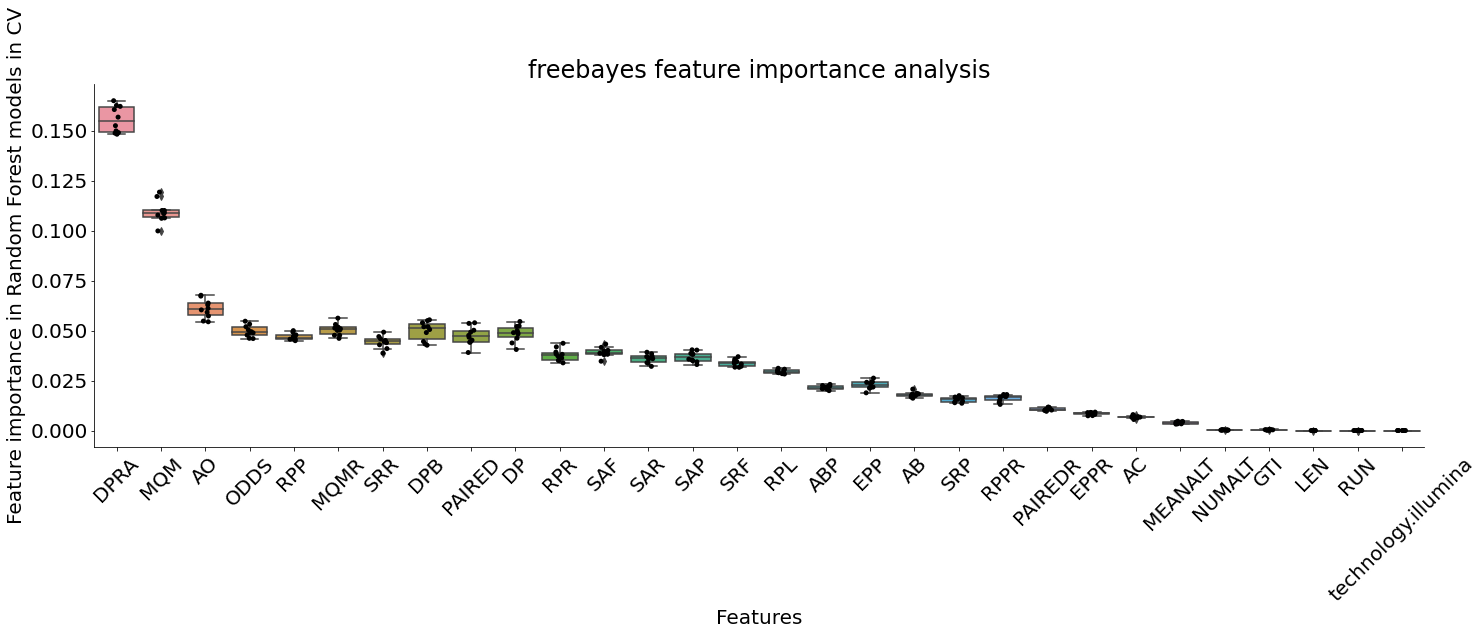

In [33]:
plt.rc('font', size=20) 
fi_pd_list = []
for idx, estimator in enumerate(cv_results['estimator']):
    fi_pd = pd.DataFrame(estimator.feature_importances_,
                         columns=['importance']).sort_values('importance', ascending=False)
    fi_pd_list.append(fi_pd)
feature_importances = pd.concat(fi_pd_list, axis=1)
feature_importances.columns = ['estimator_'+str(i) for i in range(10)]
feature_importances.index = feature_name_dict.values()
feature_importances.sort_values(by='estimator_0', ascending=False, inplace=True)
feature_importances = feature_importances[(feature_importances.T != 0).any()]
g = sns.catplot(data=feature_importances.T, kind="box",
                height=6, aspect=3.5);
g.map_dataframe(sns.stripplot,
                palette=["k"], dodge=True)
g.set_xticklabels(rotation=45)
plt.xlabel('Features')
plt.ylabel('Feature importance in Random Forest models in CV')
plt.title(method + ' feature importance analysis')
plt.show()


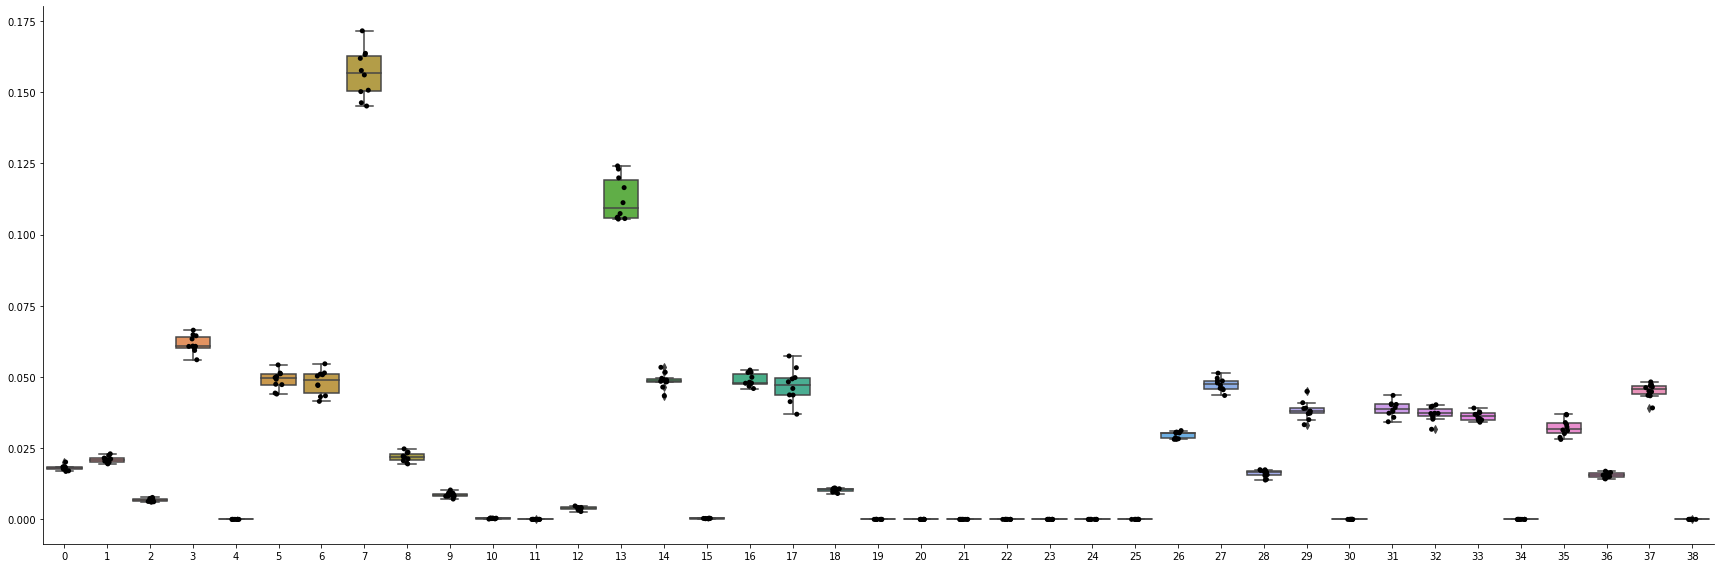

In [16]:
fi_pd_list = []
for idx, estimator in enumerate(cv_results['estimator']):
    fi_pd = pd.DataFrame(estimator.feature_importances_,
                         columns=['importance']).sort_values('importance', ascending=False)
    fi_pd_list.append(fi_pd)
feature_importances = pd.concat(fi_pd_list, axis=1)
feature_importances.columns = ['estimator_'+str(i) for i in range(10)]

import seaborn as sns 
import matplotlib.pyplot as plt
g = sns.catplot(data=feature_importances.T, kind="box",
                height=8, aspect=3);
g.map_dataframe(sns.stripplot,
                palette=["k"], dodge=True)
plt.show()

In [ ]:
callmethod_snv_allchrom[method].value_counts()
callmethod_snv_allchrom[method][callmethod_snv_allchrom[method] == 'PASS'] = 1
callmethod_snv_allchrom[method][callmethod_snv_allchrom[method] != 1] = 0

In [ ]:
forbiden_features = ['AF', 'OLD_VARIANT', 'TYPE', "cosmid_id", 'AN', "NS", 'CIGAR']
score_features = ['ODDS', 'TLOD', 'SomaticEVS', 'SSF', 'SPV']
print(features)

In [ ]:
plt.figure()
ax = plt.subplots(figsize=(10,10))
plt.rc('font', size=20) 
for feature in features:
    print(feature)
    test = 0
    try:
        pred = callmethod_snv_allchrom[feature].fillna(0).astype(float)
        test = 1
    except:
        try: 
            pred = callmethod_snv_allchrom[feature].str.split(',').str[0].fillna(0).astype(float)
            test = 1
        except:    
            test = 0
    if test == 1 and feature != 'truth' and feature not in forbiden_features:
        print('hello')
        #pred = callmethod_snv_allchrom[feature].fillna(0).astype(float)
        fpr, tpr, _ = roc_curve(callmethod_snv_allchrom['truth'].fillna(0), pred)
        if auc(fpr, tpr) < 0.5:
            print('invert')
            pred = -pred
        fpr, tpr, _ = roc_curve(callmethod_snv_allchrom['truth'].fillna(0), pred)
        print(auc(fpr, tpr))
        if auc(fpr, tpr) >= 0.9 and feature not in score_features:
            plot_roc_curve(fpr, tpr, estimator_name=feature, auc_score=auc(fpr, tpr), figax=ax, kwargs={'color':'r', 'lw': 3})
        if feature in score_features:
            plot_roc_curve(fpr, tpr, estimator_name=feature, auc_score=auc(fpr, tpr), figax=ax, kwargs={'color':'b', 'lw': 3})
        else:
            plot_roc_curve(fpr, tpr, estimator_name=None, auc_score=None, figax=ax, kwargs={'color':'grey', 'alpha': 0.5})
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.title('ROC curve of each feature of caller {}'.format(method))
#plt.grid()

In [ ]:
#plt.figure()
#ax = plt.subplots(figsize=(15,15))
#features = ['ODDS', 'AN']
##for feature in features:
#    precision, recall, _ = precision_recall_curve(concatres['truth'], concatres[feature])
#    #plt_pr_curve(fpr, tpr, estimator_name=feature, auc_score=auc(fpr, tpr), figax=ax)
#    plot_pr_curve(precision, recall, estimator_name=feature, f1_score=average_precision_score(concatres['truth'], concatres[feature]), figax=ax, kwargs={})
#    plt.ylim([-0.01,1.01])
    

plt.figure()
ax = plt.subplots(figsize=(15,15))
for feature in features:
    print(feature)
    test = 0
    try:
        pred = callmethod_snv_allchrom[feature].fillna(0).astype(float)
        test = 1
    except:
        test = 0
    if test == 1:
        print('hello')
        pred = callmethod_snv_allchrom[feature].fillna(0).astype(float)
        precision, recall, _ = precision_recall_curve(callmethod_snv_allchrom['freebayes'].fillna(0), pred)
        fpr, tpr, _ = roc_curve(callmethod_snv_allchrom['freebayes'].fillna(0), pred)
        if auc(fpr, tpr) < 0.5:
            print('invert')
            pred = -pred
        precision, recall, _ = precision_recall_curve(callmethod_snv_allchrom['freebayes'].fillna(0), pred)
        print(auc(fpr, tpr))
        if auc(fpr, tpr) >= 0.9 or feature == 'ODDS':
            plot_pr_curve(precision, recall, estimator_name=feature, f1_score=average_precision_score(callmethod_snv_allchrom['freebayes'].fillna(0), pred), figax=ax,  kwargs={'color':'r', 'lw': 3})
        else:
            plot_pr_curve(precision, recall, estimator_name=None, f1_score=None, figax=ax,  kwargs={'color':'grey', 'alpha': 0.5})
plt.ylim([-0.01,1.01])
plt.grid()

In [ ]:
average_precision_score(callmethod_snv_allchrom['truth'], callmethod_snv_allchrom['freebayes_score'].fillna(0).astype(float))